# Quicklinks
- [1. Data and Problem Definition](#1.-Data-and-Problem-Definition) 
- [2. Interpreting Feature Space](#2.-Interpreting-Feature-Space) 
  - [2.1 Interpreting Abbreviations](#2.1-Interpreting-Abbreviations)
  - [2.2 Account Information](#2.2-Account-Information)
  - [2.3 Payment Information](#2.3-Payment-Information)
  - [2.4 Invoice Information](#2.4-Invoice-Information)
  - [2.5 Customer Information](#2.5-Customer-Information)
  - [2.6 Merchant Information](#2.6-Merchant-Information)
- [3. Exploratory Data Analysis and Feature Engineering](#3.-Exploratory-Data-Analysis-and-Feature-Engineering)
  - [3.1 Zero Inflated Skewed Data With Outliers](#3.1-Zero-Inflated-Skewed-Data-With-Outliers)
  - [3.2 Missing Values](#3.2-Missing-Values)
  - [3.3 High Cardinality](#3.3-High-Cardinality)
  - [3.4 Hypothesis Testing for Mean, Variance, Correlation and Independence](#3.4-Hypothesis-Testing-for-Mean,-Variance,-Correlation-and-Independence)
      - [Difference In Mean](#Difference-in-Mean)
      - [Variance](#Variance)
      - [Correlation](#Correlation)
      - [Chi-Square Test Of Independence](#Chi-Square-Test-Of-Independence)
          - [Post Hoc Test](#Post-Hoc-Test)
  - [3.5 Transformation and Encoding](#3.5-Transformation-and-Encoding)
      - [Account Worst Status](#Account-Worst-Status)
      - [Merchant Group and Category](#Merchant-Group-and-Category)
  - [3.6 Scaling, Replacement and Elimination](#3.6-Scaling,-Replacement-and-Elimination)
  - [3.7 Imbalanced Dataset](#3.7-Imbalanced-Dataset)
      - [Class Weights](#Class-Weights)
      - [SMOTE: Synthetic Minority Oversampling Technique](#SMOTE:-Synthetic-Minority-Oversampling-Technique)
- [4. Model Building: Logistic Regression](#4.-Model-Building:-Logistic-Regression)
  - [4.1 Model Performance, Optimisation and Hyperparameter Tuning](#4.1-Model-Performance,-Optimisation-and-Hyperparameter-Tuning)
  - [4.2 Threshold Moving For Imbalanced Classification](#4.2-Threshold-Moving-For-Imbalanced-Classification)
      - [Adjusted Threshold](#Adjusted-Threshold)
      - [Optimal Threshold Using ROC Curve](#Optimal-Threshold-Using-ROC-Curve)
      - [Optimal Threshold Using Precision Recall Curve](#Optimal-Threshold-Using-Precision-Recall-Curve)
  - [4.3 Selecting Best Estimator](#4.3-Selecting-Best-Estimator)
      - [Define Business Goal & Understand Tradeoffs and Stakes](#Define-Business-Goal-&-Understand-Tradeoffs-and-Stakes)
      - [Final Predictive Model](#Final-Predictive-Model)
- [5. Deployment on AWS](#5.-Deployment-on-AWS)    
    - [5.1 App-Demo](#5.1-App-Demo)

---
# 1. Data and Problem Definition
The dataset provided appears to be a series of account statements (99976) having some pre-processed features (43) representing a time frame. As the accurate timestamp is not provided for each statement, it is unlikely that the data points are indexed in ordered time. We have to predict the probability of each customer (account holder) defaulting their next payment based on the information of their account. 

In the snapshot of the dataset below, we see:
- Some aggregated features like **account_amount_added_12_24m, account_worst_status_12_24m, num_unpaid_bills, max_paid_inv_0_24m, etc.** 
- **Default** is the dependent feature we have to predict.

In [1]:
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd

data = pd.read_csv("data/dataset.csv", sep=";")
print(data.shape)
data.head()

(99976, 43)


uuid  default  account_amount_added_12_24m  \
0  63f69b2c-8b1c-4740-b78d-52ed9a4515ac      0.0                            0   
1  0e961183-8c15-4470-9a5e-07a1bd207661      0.0                            0   
2  d8edaae6-4368-44e0-941e-8328f203e64e      0.0                            0   
3  0095dfb6-a886-4e2a-b056-15ef45fdb0ef      0.0                            0   
4  c8f8b835-5647-4506-bf15-49105d8af30b      0.0                            0   

   account_days_in_dc_12_24m  account_days_in_rem_12_24m  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   
3                        NaN                         NaN   
4                        0.0                         0.0   

   account_days_in_term_12_24m  account_incoming_debt_vs_paid_0_24m  \
0                          0.0                                  0.0   
1                          0.0                                  NaN   
2                          0.0                                  NaN   
3                          NaN                                  NaN   
4                          0.0                                  NaN   

   account_status  account_worst_status_0_3m  account_worst_status_12_24m  \
0             1.0                        1.0                          NaN   
1             1.0                        1.0                          1.0   
2             NaN                        NaN                          NaN   
3             NaN                        NaN                          NaN   
4             NaN                        NaN                          NaN   

   ...  status_3rd_last_archived_0_24m  status_max_archived_0_6_months  \
0  ...                               1                               1   
1  ...                               1                               1   
2  ...                               1                               1   
3  ...                               1                               1   
4  ...                               0                               1   

   status_max_archived_0_12_months  status_max_archived_0_24_months  \
0                                1                                1   
1                                2                                2   
2                                2                                2   
3                                1                                1   
4                                1                                1   

   recovery_debt sum_capital_paid_account_0_12m  \
0              0                              0   
1              0                              0   
2              0                              0   
3              0                              0   
4              0                              0   

  sum_capital_paid_account_12_24m  sum_paid_inv_0_12m  time_hours  \
0                               0              178839    9.653333   
1                               0               49014   13.181389   
2                               0              124839   11.561944   
3                               0              324676   15.751111   
4                               0                7100   12.698611   

   worst_status_active_inv  
0                      1.0  
1                      NaN  
2                      1.0  
3                      1.0  
4                      NaN  

[5 rows x 43 columns]

---
# 2. Interpreting Feature Space
The dataset contains 43 features of mixed data type (numeric, boolean, nominal and ordinal) representing information related to *Account, Invoices, Payment, Merchant and Customer*. We will try to build an intuition out of each feature to understand its importance in predicting the likelihood of default. Moreover, banking related terms are abbreviated for brevity.

In [3]:
print(pd.Series(data.columns))

0                                    uuid
1                                 default
2             account_amount_added_12_24m
3               account_days_in_dc_12_24m
4              account_days_in_rem_12_24m
5             account_days_in_term_12_24m
6     account_incoming_debt_vs_paid_0_24m
7                          account_status
8               account_worst_status_0_3m
9             account_worst_status_12_24m
10              account_worst_status_3_6m
11             account_worst_status_6_12m
12                                    age
13                 avg_payment_span_0_12m
14                  avg_payment_span_0_3m
15                      merchant_category
16                         merchant_group
17                               has_paid
18                     max_paid_inv_0_12m
19                     max_paid_inv_0_24m
20                          name_in_email
21       num_active_div_by_paid_inv_0_12m
22                         num_active_inv
23                      num_arch_d

## 2.1 Interpreting Abbreviations
- Looking at the name of several account related features, it is evident that the account information is aggregated over *Quarterly* and *Yearly* time frames. 
- **m** suffix appears to be representing **months** and the months over which the information is spanned is represented as **_StartingMonth_EndingMonth**.
- Value of months ranges from (0, 3, 6, 12, 24). **0** being the month when the snapshot of the account data was collected and **24** would be the number of months prior to the $0^{th}$ month. So, a feature with this range would be collective representation of last two years.
- For example, **account_worst_status_0_3m** would be the worst status associated with the account in the last three months, since the date of snapshot.
- Roughly intuiting meaning of certain banking related abbreviations encoded in the features, that might not be **"accurate"**:
  - **dc**: _Documentary Credit_ - Payment whereby the credit provider commits itself, on behalf of its customer, to pay to a merchant within a fixed period when the customer fails to pay (To support _Buy now, pay later_). 
  - **rem**: _Remitted_ - Forgiven outstanding payment or debt.
  - **term**: _Terminated_ - Terminated account. 
  - **num, max, avg, sum**: Statistical terms representing Number of, Maximum, Average and Summation respectively. 
  - **arch**: _Archived_ - Archived information relating to payment or statuses. 
  - **ok**: Could not interpret

## 2.2 Account Information
- **uuid**: Statement ID
- **account_amount_added_12_24m**: Payment added into account.
- **account_days_in_dc_12_24m**: Number of days (0 to 365) the account was in _Documentary Credit_ status from $12^{th}$ to $24^{th}$ month.
- **account_days_in_rem_12_24m**: Number of days (0 to 365) the account was in _Remitted_ status from $12^{th}$ to $24^{th}$ month.
- **account_days_in_rem_12_24m**: Number of days (0 to 365) the account was in _Terminated_ status from $12^{th}$ to $24^{th}$ month.
- **account_incoming_debt_vs_paid_0_24m**: Ratio of current debt vs paid debts from past, over span of last 2 years.
- **account_status**: Ordinal feature representing current status associated with the account. Its value ranges from 1 to 4. At first it appears to be a nominal feature, but other feature named **status_max_archived_0_12_months** storing max status value suggests that each status number has hierarchy and it describes the payment activity ordered as best (1) to worst (4). 
- **account_worst_status_0_3m**: Ordinal feature representing the worst status associated with the account in the span of months (0-3, 3-6, 6-12 and 12-24) ranging from 1 to 4. Like **status_max_archived_0_12_months**,this value is assumed to be the mode value of all the worst statuses in the span of months.   
- **num_unpaid_bills**: Number of outstanding payments.
- **status_last_archived_0_24m**: Status value that was last archived ranging from 0 to 5. (likewise $2^{nd}$ and $3^{rd}$)  
- **recovery_debt**: Amount of debt that is recovered via collection service when the customer failed to pay.

## 2.3 Payment Information
- **avg_payment_span_0_12m**: Average number of days taken to pay the outstanding payment in the span of a year (likewise 0 to 3 months). 
- **has_paid**: Boolean feature showing status of the latest payment. Maximum number of _True_ values (76570) suggests that by default it is set as _True_ until the payment is defaulted in future.
- **sum_capital_paid_account_0_12m**: Total amount paid in the span of months (0 to 12 and 12 to 24)

## 2.4 Invoice Information
- **max_paid_inv_0_12m**: Maximum amount paid out of all the invoices in the span of 0 to 12 months. (likewise 12 to 24 months)
- **num_active_div_by_paid_inv_0_12m**: Number of active invoices divided by the number of paid invoices. This feature has 20658 null values which could be the case when there are zero paid invoices.
- **num_active_inv**: Number of active invoices yet to be paid.
- **Archived features: [num_arch_dc_0_12m, num_arch_ok_0_12m,num_arch_rem_0_12m]**: Can not fully interpret these variables but making brute force guess, these features might be representing the archived information about the maximum number of days, the account was in [_Documentary Credit_, _Remitted_ or ok] status, as its values lies within 0 to 365 range. 
- **num_arch_written_off_0_12m**: Number of archived written off invoices. Marking an invoice **written_off** means acknowledging the failure of recovering the debt. (Impacts credibility of the account)
- **sum_paid_inv_0_12m**: Amount received through paid invoices in the span of a year.
- **worst_status_active_inv**: Worst status of the active invoice.

## 2.5 Customer Information
- **age**: Age of the account holder.
- **name_in_email**: Amount of information (Initials, Firstname, Lastname etc) that can be retrieved from the email address of the customer. Firstname and Lastname could be retrieved from the maximum number (36358) of accounts. This may give an idea about the authenticity of the customer.  

## 2.6 Merchant Information
- **merchant_category**: Category of the merchant receiving the payment.  
- **merchant_group**: Group that the merchant category belongs to.

---
## 3. Exploratory Data Analysis and Feature Engineering
We will use some basic data visualization techniques to analyse patterns in the data. Before that let's import some libraries. 

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# To visualise missing values
import missingno as msno

Before we perform data analysis, lets split the data into train (70%) and test (30%) sets so that there is no data leakage when we validate our model. Test data should only be used to validate and tune the model we build. It should not impact the decision we make regarding the feature selection process. We will stratify the split so that the proportion of values in the samples will be the same as that of the dataset. 

In [3]:
from sklearn.model_selection import train_test_split

# Create csv file for prediction set
data[data["default"].isna()].to_csv("data/predict.csv", sep=";", index=False)

# Drop prediction set from the data
data = data.dropna(subset=["default"])

X = data.drop(columns=['default']).copy()
y = data['default'].copy()

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=8)
eda_data = pd.concat([X_train.copy(), y_train.copy()], axis=1)

## 3.1 Zero-Inflated Skewed Data With Outliers
Three things that are very evident from the first glance at the distribution of the features are:
1. Except **time_hours** the majority of the features are right-skewed. 
2. There is a presence of outliers in almost all the features.
3. Some features have zero-inflated poisson distribution.

- Zero-inflated distribution allows generation of frequent zero-valued observations. Features representing countable entities such as _account days, payment span, number of active/paid invoices, number of written offs, and number of unpaid bills_ etc. have Poisson distribution and as $0$ is a valid value for them, we see a large number of zeros in the features. 
- _non-default_ customers are likely to pay during checkout then opting for credit, hence features like **avg_payment_span, num_active_inv, num_arch_written_off** etc., will have frequent zero values.
-Features like **account_incoming_debt_vs_paid_0_24m, num_active_inv, num_arch_written_off_12_24m** etc. have rare extreme values that cause the skewness in the data. 

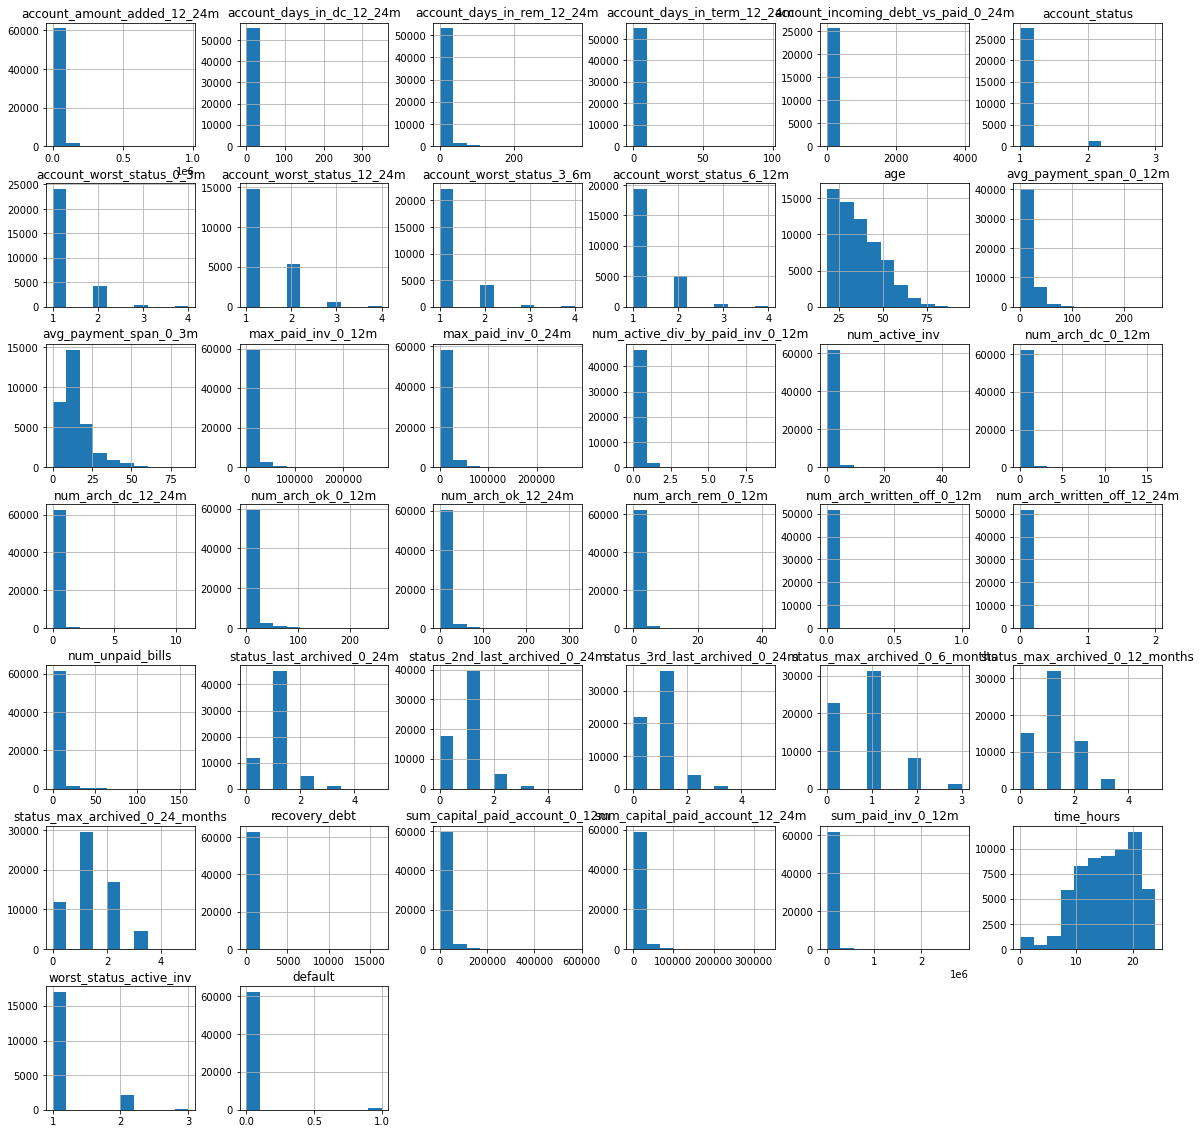

In [6]:
eda_data.hist(figsize = (20,20));

## 3.2 Missing Values
Lets visualise the missing values in the dataset and make certain observations. This can also be verified by arranging the data points in the decreasing number of missing values. 
- Due to overlapping time frames of the features, we see that presence/absence of certain features definitely affects presence/absence of other features. Bar like pattern in the below heatmap suggests continuation of missing values across features.
- For example, the number of accounts where **num_arch_written_off_0_12m** and **num_arch_written_off_12_24m** are missing are the same. This can also be verified by the nullity correlation value 1 from the correlation heatmap. 
- Similar observation holds true for features **account_days_in_term_12_24m, account_days_in_rem_12_24m, and account_days_in_dc_12_24m**.
- All the status features are interdependent and presence/absence of one of them affects presence/absence of the other.
- For example, **account_status** has missing values where **account_worst_status_0_3m** has missing values, impying there's no status information for the last three months for these accounts.

<AxesSubplot:>

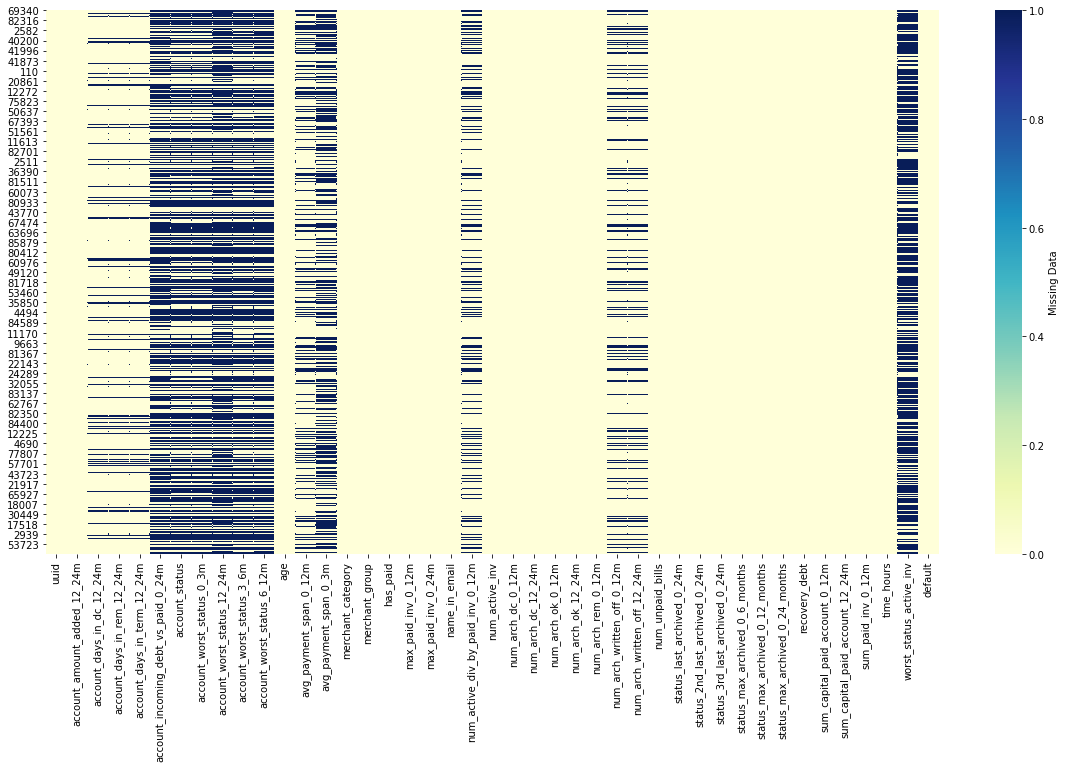

In [7]:
# Arrange the data points in the decreasing number of missing values 
# eda_data.isna().sum().sort_values(ascending=False)
plt.figure(figsize=(20,10))
sns.heatmap(eda_data.isna(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

---
We see lots of `NaN` values in features like **num_arch_written_off_12_24m, avg_payment_span_0_12m** and **num_active_div_by_paid_inv_0_12m** across all the timelines; One possible explanation of this could be presence of outstanding payment for these account entries. If the status of any active or past payment is not available or certain yet, then these features can not have a valid meaningful value. Consider the following cases happening due to outstanding payment of an active or a past invoice:

- **avg_payment_span** contains `NaN` because this might be the first payment of the account holder and it's outstanding yet so the average number of days can not be calculated.
- **num_active_div_by_paid_inv** contains `NaN` as none of the invoices are paid so division by zero yields `NaN`.
- **num_arch_written_off** contains `NaN` because the status of an outstanding payment is not certain yet and the delay has not reached a limit beyond which it can be marked as written off. 

This intuition is also supported by the following correlation matrix of missing values, it can be seen that, features **num_arch_written_off, avg_payment_span** and **num_active_div_by_paid_inv** have strong nullity correlation ranging from 0.8 to 1, suggesting presence/absence of `NaN` in one correlates with another.
Moreover, out of all the invoices (9419) that have unpaid status for last payment (`has_paid = False`) , around 97% (9121) have missing values in all **num_arch_written_off, avg_payment_span** and **num_active_div_by_paid_inv**. This bolsters the assumption that outstanding payment causes missing values in these features. 

In [8]:
print(f'\033[1mTotal number of accounts with unpaid status of last payment:\033[0m {eda_data.has_paid.value_counts().loc[False]}')
outstanding_payment = eda_data[eda_data[["num_arch_written_off_0_12m", "num_active_div_by_paid_inv_0_12m",
                                        "avg_payment_span_0_12m", "avg_payment_span_0_3m",
                                        "num_arch_written_off_12_24m"]].isna().all(1)].copy()
print(f'\033[1mTotal number of accounts with assumed outstanding payment:\033[0m {outstanding_payment.has_paid.value_counts().loc[False]}')

Total number of accounts with unpaid status of last payment: 9419
Total number of accounts with assumed outstanding payment: 9121


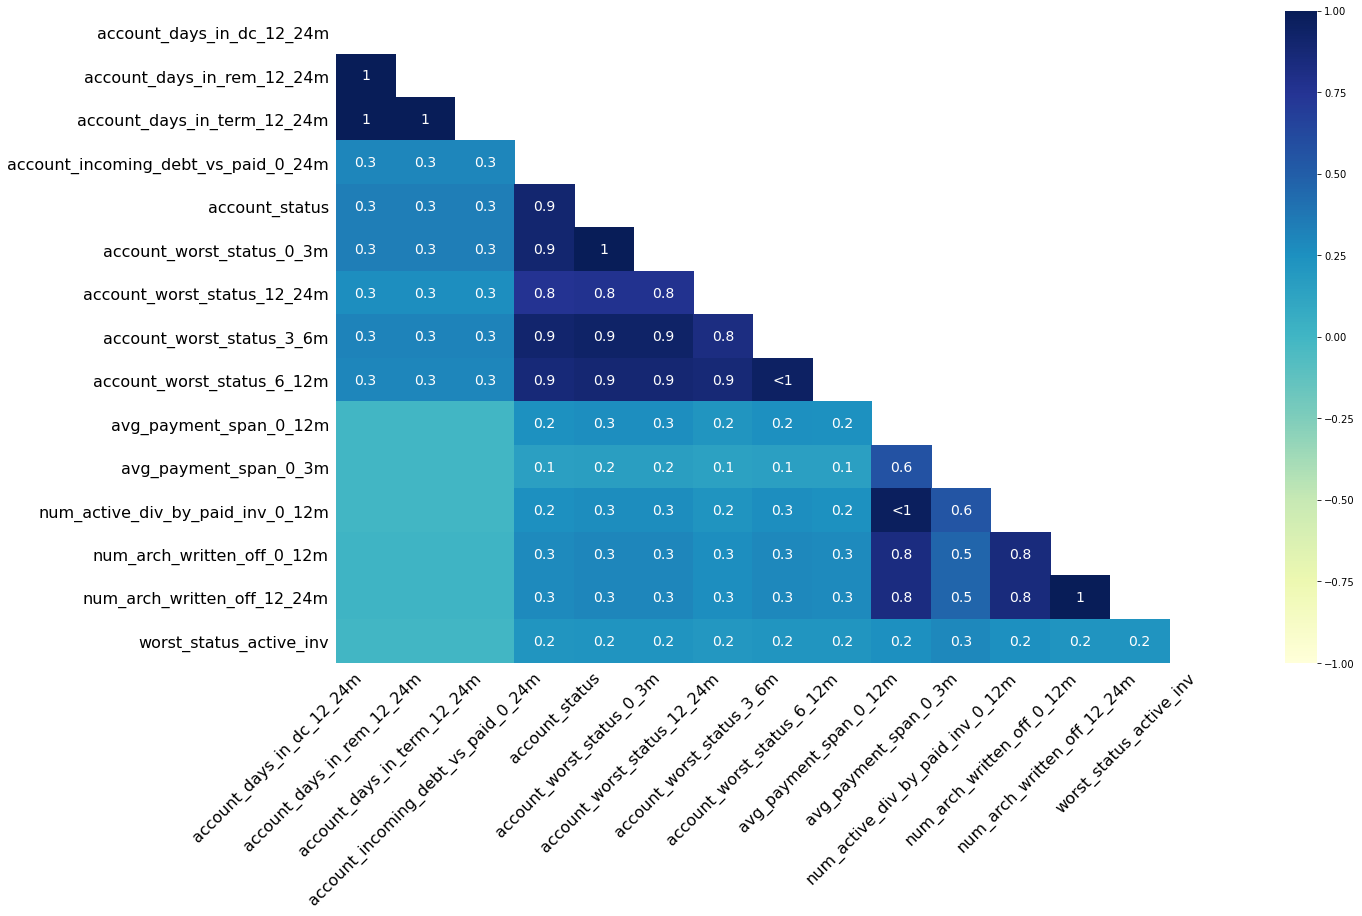

In [10]:
msno.heatmap(data, cmap='YlGnBu');

## 3.3 High Cardinality
Two nominal categories namely **merchant_group** (12) and **merchant_category** (57) has high number of levels. Let's observe the distribution of defaults among them.
- More than 70% of all defaults happen for payments to merchant groups _Entertainment, Clothing & Shoes, Leisure, Sport& Hobby and Health & Beauty_.
- New feature **frequent_default_grp** could be created that flags the data points having merchant group in **[_Entertainment, Clothing & Shoes, Leisure, Sport & Hobby and Health & Beauty_.]** 
- Compared to other groups, Food and Beverage merchant group has highest (not significant) default rate within the group, i.e. 8.4% of the total payments directed to this group defaults.
- Out of all merchant categories, _Plants & Flowers_ (15.7%) _Tobacco_ (12.5%) and _Dating Services_ (10.5%) are top 3 categories having within category default rate (>10%).

In [4]:
# Function to highlight top 4 values 
def highlight_nlargest(row):
    # Get 4 largest values of the rows
    is_large = row.nlargest(4).values
    # Apply style color if the current value is among the 4 biggest values
    return ['background-color: lightgreen' if val in is_large else '' for val in row]


mgroup_default_ct = pd.crosstab(index=eda_data['merchant_group'], columns=eda_data['default'], margins = True).sort_values(1.0, ascending=False)
mgroup_default_ct["groups_default_rate"] = (mgroup_default_ct[1.0] / mgroup_default_ct.loc["All", 1.0])*100
mgroup_default_ct["within_group_default_rate"] = (mgroup_default_ct[1.0] / mgroup_default_ct ["All"])*100
mgroup_default_ct = mgroup_default_ct.transpose()
mgroup_default_ct = mgroup_default_ct.drop("All", axis=1) # remove margin for training set
mgroup_default_ct.apply(pd.to_numeric).style.apply(highlight_nlargest, axis =1)

In [5]:
mcat_default_ct = pd.crosstab(index=eda_data['merchant_category'], columns=eda_data['default'], margins = True).sort_values(1.0, ascending=False)
mcat_default_ct["cat_default_rate"] = (mcat_default_ct[1.0] / mcat_default_ct.loc["All", 1.0])*100
mcat_default_ct["within_cat_default_rate"] = (mcat_default_ct[1.0] / mcat_default_ct ["All"])*100

# sorting by within category default rate 
# mcat_default_ct = mcat_default_ct.sort_values("within_cat_default_rate", ascending=False).transpose() 

# Retaining category default rate sorting 
mcat_default_ct = mcat_default_ct.transpose()  
mcat_default_ct = mcat_default_ct.drop("All", axis=1) # remove margin for training set
mcat_default_ct.apply(pd.to_numeric).style.apply(highlight_nlargest, axis =1)

## 3.4 Hypothesis Testing for Mean, Variance, Correlation and Independence
### Difference in Mean
- Let's use some inferential statistics to find if there is a significant difference between the means of two independent groups (default & non-default user accounts) which are related in features such as **age** and **num_unpaid_bills**. 
- Before proceeding with the statistical test, we will have to find descriptive details such as sample size, mean, median, variance, skewness etc. of the two features.

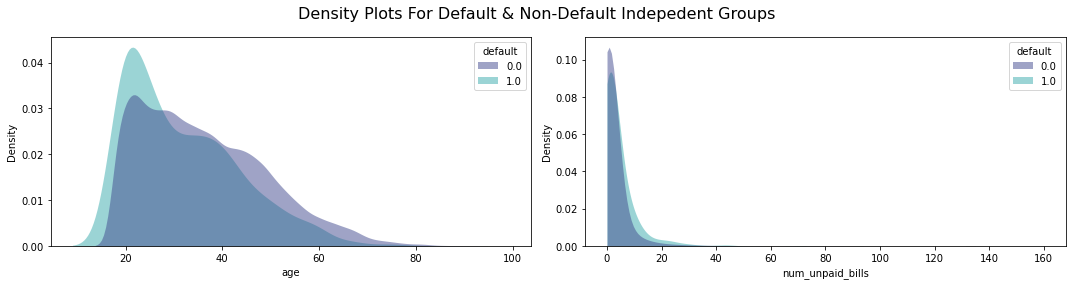

In [6]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
sns.kdeplot(data=eda_data, x="age", hue="default", fill=True, common_norm=False, alpha=.5, 
            clip=(eda_data.num_unpaid_bills.min(),eda_data.num_unpaid_bills.max()),
            palette="mako", linewidth=0, ax=ax1)
sns.kdeplot(data=eda_data, x="num_unpaid_bills", hue="default", fill=True, cut = 0,
            common_norm=False, clip=(0,eda_data.num_unpaid_bills.max()), alpha=.5, 
            palette="mako", linewidth=0, bw_method=0.5, ax=ax2)
plt.suptitle('Density Plots For Default & Non-Default Indepedent Groups', fontsize=16)
plt.tight_layout()
plt.show()

<u>**Observations:**</u>
1. We see that the two groups have different sample sizes.
2. Distribution of the **age** for both the groups are right-skewed. Average age of the users for both groups is larger than the median which suggests that the distribution of age is not normally centered around the mean. There is considerable difference in the variance of the age of users. Both distributions are unimodal and peak at the age 18. Users between age 15 to 30 have a high density of defaulting. Users beyond the age of 70 are likely to not default payment. Although the class separability is not deterministic due to major overlapping of the two distributions, there are definitely some observations that are exclusive to the two groups individually. Therefore, we will explore the groups statistically, further, to see if there's difference in the mean of these two independent populations.  
3. Distribution of **num_unpaid_bills** for both groups of users is almost the same. The difference in variance and mode is not notable. Distributions are right-skewed and unimodal. This feature alone does not provide class separability.
> 💡 **Note on Density Estimator Kernel** Since we have used Gaussian kernel density estimation to plot the density for **num_unpaid_bills**, we will get tails extending over our data range because the function applies a gaussian over each data point and sums up the densities & normalizes. In order to have better representation, before plotting the density, we are clipping the distribution in the range of **num_unpaid_bills** cutting the distribution before the value 0.


In [7]:
# Create two independent groups
default_data = eda_data[eda_data['default'] == 1][["age", "num_unpaid_bills"]]
non_default_data = eda_data[eda_data['default'] == 0][["age", "num_unpaid_bills"]]

default_summary = pd.DataFrame({'Feature': ["age", "num_unpaid_bills"], 'Variance': default_data.var().values,
                  'Mean': default_data.mean().values, 'Median': default_data.median().values,
                  'Group':["Default", "Default"], 'Mode': default_data.mode().values[0],
                  'Sample Size': [default_data.shape[0], default_data.shape[0]]})
non_default_summary = pd.DataFrame({'Feature': ["age", "num_unpaid_bills"], 'Variance': non_default_data.var().values,
                  'Mean': non_default_data.mean().values, 'Median': non_default_data.median().values,
                  'Group':["Non-Default", "Non-Default"], 'Mode': non_default_data.mode().values[0],
                  'Sample Size': [non_default_data.shape[0], non_default_data.shape[0]]})

summary = pd.concat([default_summary, non_default_summary])
summary.set_index(['Group', "Sample Size", "Feature"], inplace=True)
summary

Variance       Mean  Median  Mode
Group       Sample Size Feature                                              
Default     902         age               137.078841  31.769401    29.0    18
                        num_unpaid_bills   39.281646   3.678492     1.0     0
Non-Default 62081       age               169.179042  36.073903    34.0    18
                        num_unpaid_bills   41.089761   2.139817     0.0     0

- We aim to verify if there is difference in the mean of the two groups, a common way of doing this is to do two sample T-Test. Before using it we will verify some T-Test assumptions:
1. Two groups of samples (default and non-default), being compared, are normally distributed. 
   - Large sample size ensures the normality of the data (Central Limit Theorem). Still we will perform the Shapiro–Wilk test to restate this fact. 

In [8]:
from scipy import stats
import numpy as np

# Test normality of the groups
print(f"p-value for default group: {stats.shapiro(non_default_data.age).pvalue:.2f}")
print(f"p-value for non-default group: {stats.shapiro(default_data.age).pvalue:.2f}")

p-value for default group: 0.00
p-value for non-default group: 0.00


2. The variances of the two samples are equal. 
    - Using the F test to compare variances.

In [9]:
# Calculate F test statistic
f = np.var(np.array(non_default_data.age), ddof=1)/np.var(np.array(default_data.age), ddof=1) #calculate F test statistic 
# Define degrees of freedom
df_non_default = non_default_data.age.size-1 
df_default = default_data.age.size-1 
# Find p-value of F test statistic 
p = 1-stats.f.cdf(f, df_non_default, df_default) 
print(f"p-value for F test: {p:.2f}")

p-value for F test: 0.00


<u>**Welch’s T-Test**</u>
- Two sample T-Test assumes that the variance of the two groups is equal. From the above tests we verify that both the groups are normally distributed and have statistically significant difference in the variance of the **age** (p-value < 0.05). Do to unequality of the variance of the two groups, we will use Welch’s T-test.
- Let's first define the null hypothesis and alternate hypothesis. 

$H_0$: There is no difference in the mean age of the two population groups default and non-default. <br>
$H_1$: There is statistically significant difference in the mean age of the two groups default and non-default.

In [10]:
f_test_pvalue = stats.ttest_ind(default_data["age"], non_default_data["age"], equal_var = False).pvalue
print(f"F-test p-value: {f_test_pvalue:.2f}")

F-test p-value: 0.00


As the p-value is less than 0.05, we conclude that there is statistically significant difference in the mean of the two groups. Thus our intuition that younger people are more likely to default the payment might be true. As the **default** is not independent of the feature **age**, we will include age in the final model.  

### Variance
Let's find the features that have less than 1% variance, by applying some variance threshold. Values for these features almost remain constant. We are likely to see features with less variance as the dataset is sparse with maximum number of constant values in some features (like status features).  

In [11]:
from sklearn.feature_selection import VarianceThreshold

var_check = eda_data.copy().drop(["uuid", "default", "name_in_email", "merchant_category", "merchant_group", "has_paid"], axis=1)
var_thres = VarianceThreshold(threshold=1)
var_thres.fit(var_check)
var_thres.get_support()
constant_columns = [col for col in var_check.columns if col not in var_check.columns[var_thres.get_support()]]
constant_columns

['account_status',
 'account_worst_status_0_3m',
 'account_worst_status_12_24m',
 'account_worst_status_3_6m',
 'account_worst_status_6_12m',
 'num_active_div_by_paid_inv_0_12m',
 'num_arch_dc_0_12m',
 'num_arch_dc_12_24m',
 'num_arch_written_off_0_12m',
 'num_arch_written_off_12_24m',
 'status_last_archived_0_24m',
 'status_2nd_last_archived_0_24m',
 'status_3rd_last_archived_0_24m',
 'status_max_archived_0_6_months',
 'status_max_archived_0_12_months',
 'status_max_archived_0_24_months',
 'worst_status_active_inv']

- As expected we see majority status related features with constant variance. We will next improve performance of the _account_worst_status_ features by unifying their scores and drop remaining time spans.

### Correlation
In order to find dependence of the target variable default over the feature space, let's find out the point biserial correlation between the features and the "default" variable. Correlation value that is zero or negative shows that there is no correlation between **default** and these features. Drop these features from the modelling stage later.

In [12]:
# Correlation between nominal default variable and continuous numeric variables
corr_value = []
p_value = []
colname = []
for col in eda_data.columns.difference(["uuid", "merchant_category", "merchant_group", "has_paid","name_in_email", "status_max_archived_0_6_months", 
                                        "status_max_archived_0_12_months", "status_max_archived_0_24_months", "status_last_archived_0_24m",
                                        "status_2nd_last_archived_0_24m", "status_3rd_last_archived_0_24m"]).to_list():
    if col != "default":
        d = eda_data[["default", col]].dropna(axis=0).copy()
        corr = stats.pointbiserialr(d.default, d[col])
        colname.append(col)
        corr_value.append(corr.correlation)
        p_value.append(corr.pvalue)
corr_result = pd.DataFrame({"feature":colname, "correlation": corr_value, "pvalue": p_value})
corr_result[corr_result.pvalue>0.05].sort_values(by="pvalue", ascending=False) #only show statistically significant results

feature  correlation    pvalue
4   account_incoming_debt_vs_paid_0_24m    -0.000801  0.898124
23          num_arch_written_off_12_24m    -0.001267  0.773559
21                   num_arch_rem_0_12m     0.001679  0.673547
26       sum_capital_paid_account_0_12m     0.003756  0.345945
27      sum_capital_paid_account_12_24m     0.004324  0.277841
0           account_amount_added_12_24m     0.004797  0.228655

The correlation matrix shows that features with overlapping timeline such as [**status_max_archived_0_12_months, status_max_archived_0_24_months, status_max_archived_0_6_months, status_last_archived_0_24m, status_2nd_last_archived_0_24m, status_3rd_last_archived_0_24m**], [**num_arch_ok_0_12m** and **num_arch_ok_12_24m**] and [**max_paid_inv_0_12m** and **max_paid_inv_0_24m**] have strong positive correlation. 

To avoid collinearity among the features we will only keep features in the model that captures the latest larger timeline; Namely **status_max_archived_0_24_months, num_arch_ok_0_12m** and **max_paid_inv_0_24m**. 

In [13]:
correlation_matrix = eda_data[['sum_capital_paid_account_0_12m', 'age', "status_max_archived_0_12_months", "status_max_archived_0_24_months",
                   "recovery_debt", "status_2nd_last_archived_0_24m", "sum_capital_paid_account_12_24m", "sum_paid_inv_0_12m", 
                   "status_3rd_last_archived_0_24m", "account_amount_added_12_24m", "status_max_archived_0_6_months",
                   "status_last_archived_0_24m", "max_paid_inv_0_12m", "max_paid_inv_0_24m", "time_hours", "num_active_inv",
                   "num_arch_dc_0_12m", "num_arch_dc_12_24m", "num_arch_ok_0_12m", "num_arch_ok_12_24m", "num_arch_rem_0_12m",
                   "num_unpaid_bills"]].corr()
correlation_matrix.apply(pd.to_numeric).style.background_gradient(cmap='coolwarm').set_precision(2).set_table_styles(
[dict(selector="th",props=[('max-width', '200px')]),
        dict(selector="th.col_heading",
                   props=[("writing-mode", "vertical-rl"),
                          ('transform', 'rotateZ(180deg)'), 
                          ('height', '200px'),
                          ('vertical-align', 'top')])])

###  Chi-Square Test Of Independence
During exploratory analysis in section [3.2](#3.2-High-Cardinality), we observed that the majority of payment default happens for a few specific merchant groups. This evidence bolsters the belief that possibility of payment default depends on the type of merchant group. Let's do some hypothesis testing to verify this assumption.

$H_0$ = Merchant groups (or Merchant category) have no effect on the default values <br>
$H_1$ = Merchant groups (or Merchant category) have some effect on the default values 

In [14]:
# Test of independence for merchant group using chi-square
print(f"p-value for chi-square test (Merchant Groups): \
{stats.chi2_contingency(pd.crosstab(index=eda_data['merchant_group'], columns=eda_data['default'], margins = False))[1]}")

print(f"p-value for chi-square test (Merchant Category): \
{stats.chi2_contingency(pd.crosstab(index=eda_data['merchant_category'], columns=eda_data['default'], margins = False))[1]}")

p-value for chi-square test (Merchant Groups): 6.133184797511875e-79
p-value for chi-square test (Merchant Category): 2.059088060253296e-101


- p-value $\leq0.05$ for the test of independence shows that merchant groups/category and default values are dependent. As the Chi-Square test is an omnibus test, it shows the significance of several features in the data all at once. To elaborate, the test shows that the default feature is dependent on at least one merchant group/category. To find out which specific merchant groups and categories are responsible for this dependent relationship; we have to perform some post hoc testing. 

#### Post Hoc Test
1. Test alternate hypothesis for each merchant group and category against the default feature.<br>
$H_0$ = Merchant group $m$ (category $c$) has no effect on the default values. <br>
$H_1$ = Merchant group $m$ (category $c$) has some effect on the default values. <br>
**Note:** $m$ takes 12 values from **merchant_groups** & $c$ takes 57 values from **merchant_category**.

2. Compute p-value for each test. 
> **p-value Correction:** We have in total 12 merchant groups (i.e. 12 hypotheses) to test against our target feature **default**, with a significance level $\alpha = 0.05$. So for each of these tests we have a 5% chance of false positives (error rate). With each subsequent test this false positive rate accumulates thereby increasing the error rate by 5%. So at the end of 12 tests, the chi-square test will have a 60% error rate i.e. we will test the hypothesis against a higher p-value of 0.6. Thus to correct this p-value we will use multiple testing correction (Family-wise error rate (FWER) correction) method such as Bonferroni correction. 

In [15]:
from IPython.display import display, HTML, display_html

def post_hoc(feature, target):
    result = {}
    significant_feature = {}
    feature_coded = pd.get_dummies(feature)
    adjusted_pvalue = 0.05/feature.nunique() # Bonferroni
    for value in feature_coded:
        if stats.chi2_contingency(pd.crosstab(target, feature_coded[value]))[1] < adjusted_pvalue:
            result[value] = 'Reject Null Hypothesis H_0'
            significant_feature[value] = 1
        else:
            result[value] = 'Fail to Reject Null Hypothesis H_0'
    return result, significant_feature

chi_post_hoc_mg, significant_mgroup = post_hoc(eda_data["merchant_group"], eda_data["default"])
chi_post_hoc_mc, significant_mcat = post_hoc(eda_data["merchant_category"], eda_data["default"])

chi_post_hoc_mg = pd.DataFrame(
    data = {"Merchant Group ($m$)": chi_post_hoc_mg.keys(),
            "Conclusion": chi_post_hoc_mg.values()}).style.set_table_attributes("style='display:inline'")\
                                                          .where(lambda val: 'Reject Null Hypothesis H_0' == str(val),
                                                                 'background-color: lightgreen', subset=['Conclusion'])
chi_post_hoc_mc = pd.DataFrame(data = {"Merchant Category ($c$)": chi_post_hoc_mc.keys(),
                                  "Conclusion": chi_post_hoc_mc.values()})\
             .style.set_table_attributes("style='display:inline'")\
             .where(lambda val: 'Reject Null Hypothesis H_0' == str(val), 
                          'background-color: lightgreen', subset=['Conclusion'])

# pd.set_option("display.max_rows", None)
display_html("<div style='height: 200px'>" + chi_post_hoc_mg._repr_html_() + "\xa0" * 10 + chi_post_hoc_mc._repr_html_() + "</div>", raw=True)

Merchant Group ($m$) Conclusion 
 
 0 
 Automotive Products 
 Fail to Reject Null Hypothesis H_0 
 
 
 1 
 Children Products 
 Fail to Reject Null Hypothesis H_0 
 
 
 2 
 Clothing & Shoes 
 Reject Null Hypothesis H_0 
 
 
 3 
 Electronics 
 Reject Null Hypothesis H_0 
 
 
 4 
 Entertainment 
 Reject Null Hypothesis H_0 
 
 
 5 
 Erotic Materials 
 Reject Null Hypothesis H_0 
 
 
 6 
 Food & Beverage 
 Reject Null Hypothesis H_0 
 
 
 7 
 Health & Beauty 
 Fail to Reject Null Hypothesis H_0 
 
 
 8 
 Home & Garden 
 Fail to Reject Null Hypothesis H_0 
 
 
 9 
 Intangible products 
 Reject Null Hypothesis H_0 
 
 
 10 
 Jewelry & Accessories 
 Fail to Reject Null Hypothesis H_0 
 
 
 11 
 Leisure, Sport & Hobby 
 Fail to Reject Null Hypothesis H_0 
 
            Merchant Category ($c$) Conclusion 
 
 0 
 Adult Shoes & Clothing 
 Fail to Reject Null Hypothesis H_0 
 
 
 1 
 Automotive Parts & Accessories 
 Fail to Reject Null Hypothesis H_0 
 
 
 2 
 Bags & Wallets 
 Fail to Reject Null Hypothesis H_0 
 
 
 3 
 Body & Hair Care 
 Fail to Reject Null Hypothesis H_0 
 
 
 4 
 Books & Magazines 
 Reject Null Hypothesis H_0 
 
 
 5 
 Car electronics 
 Fail to Reject Null Hypothesis H_0 
 
 
 6 
 Children Clothes & Nurturing products 
 Fail to Reject Null Hypothesis H_0 
 
 
 7 
 Children toys 
 Fail to Reject Null Hypothesis H_0 
 
 
 8 
 Cleaning & Sanitary 
 Fail to Reject Null Hypothesis H_0 
 
 
 9 
 Collectibles 
 Fail to Reject Null Hypothesis H_0 
 
 
 10 
 Concept stores & Miscellaneous 
 Fail to Reject Null Hypothesis H_0 
 
 
 11 
 Cosmetics 
 Reject Null Hypothesis H_0 
 
 
 12 
 Costumes & Party supplies 
 Fail to Reject Null Hypothesis H_0 
 
 
 13 
 Dating services 
 Reject Null Hypothesis H_0 
 
 
 14 
 Decoration & Art 
 Fail to Reject Null Hypothesis H_0 
 
 
 15 
 Dietary supplements 
 Fail to Reject Null Hypothesis H_0 
 
 
 16 
 Digital services 
 Fail to Reject Null Hypothesis H_0 
 
 
 17 
 Diversified Health & Beauty products 
 Fail to Reject Null Hypothesis H_0 
 
 
 18 
 Diversified Home & Garden products 
 Fail to Reject Null Hypothesis H_0 
 
 
 19 
 Diversified Jewelry & Accessories 
 Fail to Reject Null Hypothesis H_0 
 
 
 20 
 Diversified children products 
 Fail to Reject Null Hypothesis H_0 
 
 
 21 
 Diversified electronics 
 Fail to Reject Null Hypothesis H_0 
 
 
 22 
 Diversified entertainment 
 Reject Null Hypothesis H_0 
 
 
 23 
 Diversified erotic material 
 Reject Null Hypothesis H_0 
 
 
 24 
 Education 
 Reject Null Hypothesis H_0 
 
 
 25 
 Electronic equipment & Related accessories 
 Fail to Reject Null Hypothesis H_0 
 
 
 26 
 Erotic Clothing & Accessories 
 Fail to Reject Null Hypothesis H_0 
 
 
 27 
 Event tickets 
 Fail to Reject Null Hypothesis H_0 
 
 
 28 
 Food & Beverage 
 Reject Null Hypothesis H_0 
 
 
 29 
 Fragrances 
 Fail to Reject Null Hypothesis H_0 
 
 
 30 
 Furniture 
 Fail to Reject Null Hypothesis H_0 
 
 
 31 
 General Shoes & Clothing 
 Fail to Reject Null Hypothesis H_0 
 
 
 32 
 Hobby articles 
 Fail to Reject Null Hypothesis H_0 
 
 
 33 
 Household electronics (whitegoods/appliances) 
 Fail to Reject Null Hypothesis H_0 
 
 
 34 
 Jewelry & Watches 
 Fail to Reject Null Hypothesis H_0 
 
 
 35 
 Kitchenware 
 Fail to Reject Null Hypothesis H_0 
 
 
 36 
 Music & Movies 
 Fail to Reject Null Hypothesis H_0 
 
 
 37 
 Musical Instruments & Equipment 
 Fail to Reject Null Hypothesis H_0 
 
 
 38 
 Non 
 Fail to Reject Null Hypothesis H_0 
 
 
 39 
 Office machines & Related accessories (excl. computers) 
 Fail to Reject Null Hypothesis H_0 
 
 
 40 
 Personal care & Body improvement 
 Fail to Reject Null Hypothesis H_0 
 
 
 41 
 Pet supplies 
 Fail to Reject Null Hypothesis H_0 
 
 
 42 
 Pharmaceutical products 
 Fail to Reject Null Hypothesis H_0 
 
 
 43 
 Plants & Flowers 
 Reject Null Hypothesis H_0 
 
 
 44 
 Prescription optics 
 Fail to Reject Null Hypothesis H_0 
 
 
 45 
 Prints & Photos 
 Fail to Reject Null Hypothesis H_0 
 
 
 46 
 Safety product

- Post hoc test shows that the relationship of dependence between **default** and **merchant group** proved during the chi-sqaure test is actually contributed by 6 merchant groups namely _Clothing & Shoes, Electronics, Entertainment, Erotic Materials, Food & Beverage and Intangible products._ Similarly 11 merchant categories namely _Books & Magazines, Cosmetics, Dating services, Diversified entertainment, Diversified erotic material, Education, Food & Beverage, Plants & Flowers, Tobacco, Video Games & Related accessories, Youthful Shoes & Clothing_ are responsible for dependence of **merchant_category** on the **default** value. So out of all the 12 groups and 57 categories we will only retain 6 groups and 11 categories by creating a mapper in the next section.

## 3.5 Transformation and Encoding
### Account Worst Status
From the previous section we found that **account_worst_status** related features have less than 1% variance. We can combine the performance of these status features spanned over multiple time frames and form a new composite feature **performance_score**. 
- As the worst status features are ordinal, they can be treated as Likert scale from psychometry.
- Due to continuous encoding of status variables it is safe to assume that the categorical values are equispaced, meaning implied; each worst status differs from previous status (towards best) and next next status (towards worst) by equal distance.
- Adding status values (1-4) across all the spans (0-3, 3-6, 6-12, 12-24) for each data point will create new continuous feature having values in the range [4-16].

In [16]:
from sklearn.feature_selection import chi2

acc_status_performance = eda_data[['account_worst_status_0_3m','account_worst_status_3_6m', 'account_worst_status_6_12m', 'account_worst_status_12_24m']].copy() 
acc_status_performance["performance_score"] = acc_status_performance.sum(axis=1)
acc_status_performance = acc_status_performance.fillna(0)
f_p_values=chi2(acc_status_performance, y_train)
f_values=pd.Series(f_p_values[0])
f_values.index=acc_status_performance.columns
f_values.sort_values(ascending=False)

performance_score              1483.096164
account_worst_status_0_3m       443.317726
account_worst_status_6_12m      376.127937
account_worst_status_3_6m       337.393959
account_worst_status_12_24m     328.342778
dtype: float64

- Results of the Chi Square test shows that **performance_score** has the highest statistical value and least p-value among all the worst_status features. Thus, we will use this feature in our model building and drop the remaining four features.

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
acc_worst_status_features = ['account_worst_status_0_3m','account_worst_status_3_6m', 
                             'account_worst_status_6_12m', 'account_worst_status_12_24m']
class AccountStatusFeatureTransformer(BaseEstimator, TransformerMixin):
        
    def fit(self, x, y=None):
        return self

    def transform(self, x):
        x["performance_score"] = x.sum(axis=1)
        x.drop(['account_worst_status_0_3m', 'account_worst_status_3_6m', 'account_worst_status_6_12m', 'account_worst_status_12_24m'], axis=1, inplace=True)
        return x

### Merchant Group and Category
- Due to the high cardinality of these features it is not efficient to encode them using a technique like One Hot Encoding as it will expand the feature space without adding much information. 
- So we will map each merchant group/category with 1 or 0. If the group/category was found significant in the [Chi Square Test Of Independence](#Chi-Square-Test-Of-Independence) it will be assigned 1 else 0.

> **Note**: Earlier we had used frequency encoding over these features, that is we had replaced each level of the categorical feature with its frequency of occurrence in the data. For example, the merchant group _Entertainment_ was replaced by 30809. Drawback of this approach is that it treats merchant groups/categories with equal frequency as the same that can cause loss of information. As this transformation brought down the performance of the linear model we applied later, it was removed from the final learning pipeline. It is observed that the new encoding method improves the True Positive and True Negative predictions.

In [18]:
merchant_features = ["merchant_category", "merchant_group"]

class MerchantFeatureTransformer(BaseEstimator, TransformerMixin):
        
    def fit(self, x, y=None):
        # Create frequency mapper for merchant category and group
        self.merchant_category_mapper = significant_mcat
        self.merchant_group_mapper = significant_mgroup

        return self

    def transform(self, x):
        x['merchant_category'] = x['merchant_category'].apply(lambda cat: self.merchant_category_mapper.get(cat, 0))
        x['merchant_group'] = x['merchant_group'].apply(lambda grp: self.merchant_group_mapper.get(grp, 0))

        return x

## 3.6 Scaling, Replacement and Elimination
**Drop Features:**<br/>
- We will be dropping some of the features that has missing values such as **worst_status_active_inv, account_incoming_debt_vs_paid_0_24m, account_status, avg_payment_span_0_3m, avg_payment_span_0_12m, num_arch_written_off_12_24m, num_arch_written_off_0_12m**.
- Drop features that are not relevant to the model such as **uuid** and **name_in_email**.
- Based on insights generated in [section 3.4](##Correlation), drop features [namely **sum_capital_paid_account_0_12m, sum_capital_paid_account_12_24m, account_amount_added_12_24m** and **num_arch_rem_0_12m**] that do not have correlation with the target variable **default**.
- Drop features causing collinearity such as  **status_max_archived_0_12_months, status_max_archived_0_6_months, status_last_archived_0_24m, status_2nd_last_archived_0_24m, status_3rd_last_archived_0_24m, num_arch_ok_12_24m**, and **max_paid_inv_0_12m** [section 3.4](#Correlation)
- Drop low variance feature **has_paid**.

**Impute Missing Values**<br/>
- Impute missing values with zero in features such as **num_active_div_by_paid_inv_0_12m, account_days_in_dc_12_24m, account_days_in_term_12_24m, account_days_in_rem_12_24m**

**Scaling and Transformation**<br/>
- Create a separate list of the numeric features that are skewed. Then scale the numeric features using appropriate scaling techniques to bring their values in the same range for faster convergence.
- As there are outliers in the skewed data we can not use mean to scale them,  instead we will use `RobustScaler()` that is robust to the outliers in the data. It removes the median and then uses quantile range to scale the features.
- For non-skewed features use standardisation to scale the data.
- Apply transformation to _account_worst\_status_ features and this will remove features namely **account_worst_status_0_3m, account_worst_status_3_6m, account_worst_status_6_12m, account_worst_status_12_24m**.

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer 

dropped_features = ['uuid', 'name_in_email', 'has_paid', 'worst_status_active_inv', 'account_incoming_debt_vs_paid_0_24m', 
                    'account_status', 'avg_payment_span_0_3m', 'avg_payment_span_0_12m', 'num_arch_written_off_12_24m',
                    'num_arch_written_off_0_12m', 'sum_capital_paid_account_0_12m', 'sum_capital_paid_account_12_24m',
                    'account_amount_added_12_24m', 'num_arch_rem_0_12m', 'status_max_archived_0_12_months', 
                    'status_max_archived_0_6_months', 'status_last_archived_0_24m', 'status_2nd_last_archived_0_24m',
                    'status_3rd_last_archived_0_24m', 'num_arch_ok_12_24m', 'max_paid_inv_0_12m']

missing_value_features = ['num_active_div_by_paid_inv_0_12m', 'account_days_in_dc_12_24m', 
                           'account_days_in_term_12_24m', 'account_days_in_rem_12_24m']

missing_value_transformer = Pipeline(steps=[
                                            ('simpleimpute',  SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),
                                            ('stdscaler',  StandardScaler())
                                           ])

numeric_features = ['age', "time_hours"]

numeric_transformer = Pipeline(steps=[('stdscaler',  StandardScaler())])

skewed_features = ["recovery_debt", "sum_paid_inv_0_12m", "max_paid_inv_0_24m", "num_active_inv",
                   "num_arch_dc_0_12m", "num_arch_dc_12_24m", "num_arch_ok_0_12m", "num_unpaid_bills"]

skewed_transformer = Pipeline(steps=[ ('robustscaler',  RobustScaler())])

nominal_features = ["status_max_archived_0_24_months"]

nominal_transformer = Pipeline(steps=[('stdscaler',  OneHotEncoder(handle_unknown="ignore"))])

feat_transformer = ColumnTransformer(transformers=[
                                                   ('drop_column', 'drop', dropped_features),
                                                   ('missing_value_processing', missing_value_transformer, missing_value_features),
                                                   ('acc_worst_status_processing', AccountStatusFeatureTransformer(), acc_worst_status_features),
                                                   ('numeric_processing', numeric_transformer, numeric_features),
                                                   ('skewed_processing', skewed_transformer, skewed_features),
                                                   ('nominal_processing', nominal_transformer, nominal_features),
                                                   ('merchant_processing', MerchantFeatureTransformer(), merchant_features)
                                                  ], remainder='passthrough')

## 3.7 Imbalanced Dataset
- The dataset is highly imbalanced with only 902 default cases (1.43%) among 62983 total data points. If we create a model using this proportion of the classes, it will be highly biased towards the majority class i.e. negative class (non-default). To do the comparative analysis, we will train the model on the training set containing an imbalanced proportion of classes (base model) and test it against the test data having the same representation of the class (stratified samples). To handle the imbalance we can either use class weights or do oversampling. 

### Class Weights
If we do not want to generate new samples of the minority class than we can simply train the model to penalize the misclassification of the minority class more. In sklearn, this can be accomplished by setting _class_weight_ hyperparameter. Giving more weightage to the minority class in the cost function of the algorithm will give higher penalty to the minority class and the model will emphasize on reducing the errors for it. Setting _class_weight_ value as `balanced` would assign weight based on the frequency of each class as:

$$weight_{c} = \frac{\text{Number of Samples}}{\text{Number of Classes } \times \text{ Number of samples of Class } c} \ \ \ \text{Where,} \ c \in \{0,1\}$$


### SMOTE: Synthetic Minority Oversampling Technique
Creating a new dataset by applying an oversampling technique on the training set will generate similar looking data as in minority class to regain balanced classes. SMOTE will alter the data and increase the samples of the minority class (default = 1). We will be using imbalanced learn's pipeline to do that as it carefully only applies the SMOTE at the training stage to avoid any data leak.

In [19]:
y_train.value_counts()

0.0    62081
1.0      902
Name: default, dtype: int64

## 4. Model Building: Logistic Regression
- As this is a binary classification problem we will implement an eager learner to perform supervised learning and generate description of our target function (default). - Logistic regression is a fast learner compared to other lazy learners like KNN and Naive Bayes. 
- Using SVM with Radial Basis Function kernel (RBF) may significantly improve the performance for the current model. That said, SVM is not incremental and it stores the distance between the training points as $NxN$ matrix, thus taking too long to learn the model when the feature space is large.
- We are assuming that the decision boundary would be linear.
- Logistic regression will build linear approximations of the decision boundary by reducing the quadratic cost function using Hessian matrix. Building hessian matrix is computation heavy as it involves computing second order derivatives. 
- To improve this computational speed we will use the optimization algorithm _Limited-memory Broyden–Fletcher–Goldfarb–Shanno Algorithm (lbfgs)_ which will only create an approximation of the Hessian matrix. We will implement this using Sklearn's `LogisticRegression` implementation with `lbfgs` solver.
- We will create three variations of the model preprocessing:
1. **Base Model:** In this model we will not apply any technique to handle the class imbalance.
2. **Cost Sensitive Model:** In this model we will assign balanced class weights that will penalize minority class misclassification more.
3. **SMOTE Model:** In this model we will apply SMOTE to oversample the data.

In [47]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.linear_model import LogisticRegression

pipeline_base = imbpipeline(steps = [['transform_features', feat_transformer],
                                ["classifier", LogisticRegression(random_state=11,
                                                                  max_iter=5000)]])

pipeline_class_weight = imbpipeline(steps = [['transform_features', feat_transformer],
                                ["classifier", LogisticRegression(random_state=11, class_weight="balanced",
                                                                  max_iter=5000)]])

pipeline_smote = imbpipeline(steps = [['transform_features', feat_transformer],
                                ['smote', SMOTE(random_state=11)],
                                ["classifier", LogisticRegression(random_state=11,
                                                                  max_iter=5000)]])

### 4.1 Model Performance, Optimisation and Hyperparameter Tuning 
- To evaluate the generalisation of our model on the unseen data we will use cross validation with 5 folds. As we have an imbalanced dataset, stratified sampling would be performed with cross validation. So for each $k^{th}$ sample of data, the train and test split will have equal proportion of the target feature.
- Inverse of regularization strength $C$ is a hyperparameter governing the penalty applied to the high value of parameters, to prevent overfitting. 
- Default value for $C$ is 1. We will test varying values of this hyperparameter to find the best estimator for the prediction.
- Smaller values of $C$ suggests that we want to apply regularization to penalise high values of parameters, assuming the sample is not the correct representation of the population. Higher values of $C$ will restrict application of regularization.
- For the SMOTE model, the sampling strategy is kept as a hyperparameter that tests values ranging from $[0.1, 0.2, \ldots, 1.0]$. It is the ratio of the number of positive class samples after resampling to the number of majority class samples. For example, sampling strategy 0.5 means there would be 33.34% default (positive) class samples and 66.66% non-default class samples. 
- Defining prediction results:
    - **True Positive (TP):** Event of predicting default when the true outcome is default. 
    - **True Negative (TN):** Event of predicting non-default when the true outcome is non-default. 
    - **False Positive (FP):** Event of predicting default when the true outcome is non-default.
        - **Cost/Consequences:** 1. Loyal customers are declined purchase. 
            - 2. Fuels customer attrition.
            - 3. Company has to set up follow up procedures to verify the customer's credibility.
    - **False Negative (FN):** Event of predicting non-default when the true outcome is default. 
        - **Cost/Consequences:** 1. Company has to bear the credit loss due to the credit that defaults or is unrecoverable. 
            - 2. Company has to use debt collection agencies to recover the outstanding balance. 
            - 3. Customers will be denied the next purchase and it reduces the customer's credit score.
- As we are dealing with an imbalanced dataset, we can not solely use accuracy as the metric of model performance. When the majority of samples belong to one class, the best model would be the one that makes predictions about both positive (default) and negative (non-default) classes accurately, i.e. a model that balances sensitivity and specificity.  
- Thus we use the `roc-auc` score as a metric of model performance, later we find the logistic regression threshold value  on the _ROC_ curve for which the balance between False positive (FP) and True Positive (TP) rates is optimal.

In [48]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)

param_grid = {"classifier__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_search_base = GridSearchCV(estimator=pipeline_base,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search_class_weight = GridSearchCV(estimator=pipeline_class_weight,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

param_grid_smote = {"classifier__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                    "smote__sampling_strategy": np.linspace(0.1,1.0,10)}


grid_search_smote = GridSearchCV(estimator=pipeline_smote,
                           param_grid=param_grid_smote,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

# Fit all the models
grid_search_base.fit(X_train, y_train)
grid_search_class_weight.fit(X_train, y_train)
grid_search_smote.fit(X_train, y_train);

- Default value for the Sklearn's Logistic Regression threshold is 0.5. We are keeping it as a variable to tweak this parameter later.
- As expected, the base model is performing very well on the test data in terms of accuracy because of the same proportion of classes in both training and testing set. Out of 26607 non-default samples, 26594 have been predicted correctly. But due to the inherent imbalance in the data, this model is biased towards the majority class. Thus only 7 default samples are predicted correctly out of 386 giving a poor recall score of 1.8%.
- Both the models handling imbalance: Cost Sensitive model & SMOTE model, gives higher recall score (~ 84%) due to enhanced representation of the minority class (default samples). However, adhering to the precision-recall tradeoff these models give poor precision of around 5%. 
- An important observation to make here is that Smote inherently handles (by sampling strategy) the imbalance before training the model and performs resampling to equalize (0.5/0.5) the proportion of positive (default) vs negative (non-default) classes (choosen as hyperparameter). So when we test the best estimator model over the test data-set (that still has class imbalance), we get poor precision and lots of False Positives. Due to major class imbalance in test data and no imbalance in the training set both Cost Sensitive model & SMOTE model behave as a Low Precision High Recall Model.
- As precision-recall depends a lot on the logistic regression threshold, we will tweak this parameter in the next section to improve the performance of the SMOTE model.

In [49]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve #plots
from numpy import argmax

# threshold for Logistic Regression
class_threshold = 0.5

def performance_scores(grid_search, class_threshold=0.5, roc_plot=False, precision_recall_plot=False):
    y_pred_prob = grid_search.best_estimator_.predict_proba(X_test)[:,1]
    if roc_plot:
        # Compute roc curve
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        # Find the index of the threshold with the largest J statistics
        max_jstat_index = argmax(tpr - fpr)
        class_threshold = thresholds[max_jstat_index] # New optimal threshold
        y_pred = (grid_search.best_estimator_.predict_proba(X_test)[:,1]>=class_threshold).astype(int)
        plot_param = [fpr, tpr, max_jstat_index] 
        
    elif precision_recall_plot:
        # Compute precision-recall curve
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
        # Find index where F-Score is maximum
        max_fscore_index = argmax((2 * precision * recall) / (precision + recall))
        class_threshold = thresholds[max_fscore_index] # New optimal threshold
        y_pred = (grid_search.best_estimator_.predict_proba(X_test)[:,1]>=class_threshold).astype(int)
        plot_param = [precision, recall, max_fscore_index]

    else: 
        y_pred = (grid_search.best_estimator_.predict_proba(X_test)[:,1]>=class_threshold).astype(int)
        plot_param = []
        
    cv_score = grid_search.best_score_
    test_score = grid_search.score(X_test, y_test)
    accuracy_value = accuracy_score(y_test,y_pred)
    precision_value = precision_score(y_test,y_pred)
    recall_value = recall_score(y_test,y_pred)
    f1_value = f1_score(y_test,y_pred)
#     tn, fp, fn, tp = confusion_matrix(y_test == 1.0, y_pred_prob > class_threshold).ravel()
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    return [class_threshold, cv_score, test_score, accuracy_value, precision_value, 
            recall_value, f1_value, tn, fp, fn, tp] + plot_param

In [50]:
performance = {'Models': ['Threshold', 'CV Score', 'Test Score', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'TN', 'FP', 'FN', 'TP'],
               'Base Model': performance_scores(grid_search_base, class_threshold),
               'Cost Sensitive Model': performance_scores(grid_search_class_weight, class_threshold),
               'Smote Model': performance_scores(grid_search_smote, class_threshold)}

results = pd.DataFrame(performance, columns = ['Models', 'Base Model', 'Cost Sensitive Model', 'Smote Model'])
results.set_index("Models", inplace=True)
results = results.T
results.reset_index().rename(columns={'index': 'Models'})
results.apply(pd.to_numeric).style.highlight_max(color = 'lightgreen', axis = 0)

### 4.2 Threshold Moving For Imbalanced Classification
- Due to difference in the proportion of default and non-default samples in the test data, when we fit the model onto it, we get a low precision high recall result.
- In the training set the positive class to the negative class ratio is (0.0143/0.9857).
- The logistic regression makes assumption that the distribution of the data in the test set matches the distribution of the data in the training set. The sampling strategy that we use (selected using hyperprameter tunining) for SMOTE, in the model, augments the training data by only adding synthetic positive samples. Meanwhile, the number of the majority class samples remains the same. So after oversampling, the class balance in the training set changes to (0.5/0.5) i.e. equal samples of default and non-deafult classes.  
- This violates the assumption of the statistical model. Model is able to learn the patterns of the positive classes using samples generated through oversampling but it causes the classifier to over-predict positive instances, resulting in high number of false positives.
- By default the logistic regression mode uses 0.5 value as the decision threshold. We will use various threshold moving methods to find an optimal decision threshold that reduces false positive rate and see if it does any better than the model we have already built.

#### Adjusted Threshold
- Change the value of threshold from 0.5 to $\frac{0.5}{k}$. Where, k is:
$$
\begin{align}
    k & = \frac{\text{Fraction of default accounts after SMOTE $F^{min}_{os}$}}{\text{Fraction of default accounts before SMOTE (Training Set) $F^{min}_{train}$}} 
\end{align}
$$

- We will find the positive (minority) class percentage using the SMOTE sampling ratio that the `best_estimator_` selects. We are only oversampling the minority class, under that assumption, oversampling ratio in `imblearn` is defined as:

$$\alpha_{os}= \frac{\text{Number of samples in the minority class after oversampling $N^{min}_{os}$}}{\text{Number of samples in the majority class $N^{maj}$}} \ \ \ \text{Where, } N^{maj}_{os} = N^{maj}_{train} = N^{maj}$$

- Using equations of $k$ and $\alpha_{os}$ with the total training samples:

$$
\begin{align}
N^{min}_{os} + N^{maj}_{os} & = N_{train} \\
N^{min}_{os} + N^{maj} & = N_{train} \ \because \text{only oversampling minority class} \\
\frac{N^{min}_{os}}{N^{min}_{os}} + \frac{N^{maj}}{N^{min}_{os}} & = \frac{N_{train}}{N^{min}_{os}} \\
1 + \frac{1}{\alpha_{os}} & = \frac{1}{F^{min}_{os}} \\
F^{min}_{os} & = \frac{\alpha_{os}}{1 + \alpha{os}}
\end{align}
$$

- This method chooses 0.014321 as optimal threshold.

In [51]:
threshold_moving = {}
threshold_moving["Techniques"]= ['Threshold', 'CV Score', 'Test Score', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'TN', 'FP', 'FN', 'TP']
threshold_moving["Default Threshold"] = results.loc["Smote Model"].tolist()
alpha_os = grid_search_smote.best_params_["smote__sampling_strategy"] 
k = (alpha_os/(1 + alpha_os)) / (y_train.value_counts()[1.0]/len(y_train))
adjusted_threshold = 0.5/k
threshold_moving["Adjusted Threshold"] = performance_scores(grid_search_smote, adjusted_threshold)

#### Optimal Threshold Using ROC Curve
- ROC curve summarises the tradeoff between True Positive Rate (TPR) and False Positive Rate (FPR) for different probability thresholds. Though ROC curves with an imbalanced dataset can be misleading, we will find an optimal threshold that balances TPR & FPR and plug it in the existing model to verify if it improves the performance.
- This method chooses 0.464280 as optimal threshold which is near to the default threshold 0.5.
> 💡 **Intuition :** Ideal model should predict both the True Negatives and True Positives correctly, it should not be biassed towards predicting one class. So an optimal threshold would yield high TPR & TNR (maximisation problem). We know that $TNR = 1 - FPR$, so we find an average threshold value between TPR and TNR i.e. (1 - FPR) that yields a low FPR while keeping a reasonable TPR. As TPR and FPR are dependent on each other, we use the geometric mean of these values to compute the average i.e. $\sqrt[2]{TPR \times (1 - FPR)}$. Goal is to maximise this mean which is the same as maximising $(TPR - FPR)$.
Youden's $J$ statistic states that $J = TPR + TNR - 1$. Reframing in terms of FPR, $J$ would be $J= TPR - FPR$. Thus we find a value on the ROC curve that maximises J statistic.

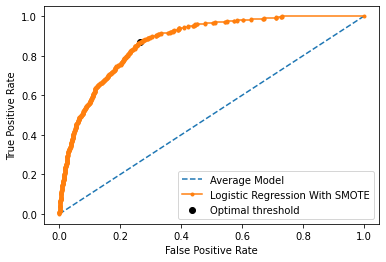

In [52]:
# [fpr, tpr, thresholds, class_threshold, cv_score, test_score, accuracy_value, precision_value, recall_value, f1_value, tn, fp, fn, tp]
performance_scores_roc = performance_scores(grid_search_smote, roc_plot=True)
threshold_moving["ROC Threshold"] = performance_scores_roc[:-3]
fpr, tpr, threshold_index = performance_scores_roc[-3:]
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='Average Model')
plt.plot(fpr, tpr, marker='.', label='Logistic Regression With SMOTE')
plt.scatter(fpr[threshold_index], tpr[threshold_index], marker='o', color='black', label='Optimal threshold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### Optimal Threshold Using Precision-Recall Curve
- Precision-Recall curve summarises the tradeoff between positive predictive value and sensitivity for different probability thresholds. Precision, Recall analysis is used when we have a large number of negative class samples over the positive class (here default class). For such imbalanced data we are more interested in building a model that correctly predicts the minority class as correct prediction of negative class (large number of True Negatives) is highly likely due to its dominant representation in the data.
> 💡 **Intuition :** Optimal threshold will be the average value between precision and recall that balances correct prediction of True positives and keeping False Positive low. Precision $(\frac{TP}{TP + FP})$ and Recall $(\frac{TP}{TP + FN})$ are just differently scaled versions of TPs, as there's inverse relationship between Recall and Precision we choose harmonic mean of these mterics as threshold value, which is nothing but F-Score.

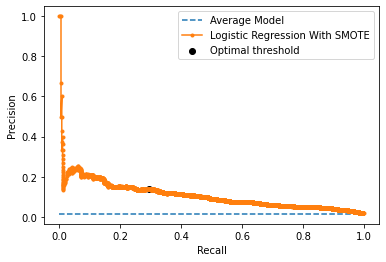

In [53]:
performance_scores_pr = performance_scores(grid_search_smote, precision_recall_plot=True)
threshold_moving["Precision-Recall Threshold"] = performance_scores_pr[:-3]
precision, recall, threshold_index = performance_scores_pr[-3:]

# plot the roc curve for the model
average_model = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [average_model,average_model], linestyle='--', label='Average Model')
plt.plot(recall, precision, marker='.', label='Logistic Regression With SMOTE')
plt.scatter(recall[threshold_index], precision[threshold_index], marker='o', color='black', label='Optimal threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

### 4.3 Selecting Best Estimator
- The **Adjusted Threshold** model predictions are able to identify 100% of the default samples, but it nearly misclassifies 85% of the non-default samples, predicting with such a high false positive rate (FPR) will not give seamless experience to the customers using the application. We aim to identify defaulters with high accuracy and at the same time we also don’t want to decline purchase requests from loyal customers. With 0 false negatives (FN), the adjusted threshold model is behaving like a constant scoring model that majorly predicts positive class (default) for all the samples. 
- The **ROC Threshold** is near to the default threshold 0.5 so, it has only improved the recall score a bit also increasing FPR thereby.
- The **Precision-Recall Threshold** results in the least number of False Positives (only 2.6 %) this is desirable if we do not want to flag a large number of accounts as defaulters incorrectly at the cost of getting higher recall.  Only 29% of all the default samples are predicted correctly resulting in a high False Negative number. 

In [54]:
threshold_moving_results = pd.DataFrame(threshold_moving, columns = ['Techniques', 'Default Threshold', 'Adjusted Threshold', 'ROC Threshold', 'Precision-Recall Threshold'])
threshold_moving_results.set_index("Techniques", inplace=True)
threshold_moving_results = threshold_moving_results.T
threshold_moving_results.reset_index().rename(columns={'index': 'Techniques'})
threshold_moving_results["FPR"] = (threshold_moving_results["FP"] / (threshold_moving_results["FP"] + threshold_moving_results["TN"])) * 100
threshold_moving_results.apply(pd.to_numeric).style.highlight_max(color = 'lightgreen', axis = 0, subset=['Threshold', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'TN', 'FP', 'FN', 'TP', 'FPR'])

#### Define Business Goal & Understand Tradeoffs and Stakes
- Before deciding the optimal threshold we must define the end goal we want to achieve by using the insights from the model. The two prominent business goals for executing payment default prediction task would be:
1. **Find all the accounts that are likely to _Default_.** <br>
If it is not  much of a concern that a large number of accounts are incorrectly predicted to be at risk of defaulting the next payment; the business goal is to solely identify as many positive (likely to default) cases as possible, then, we should choose a threshold strategy that gives **_LOW PRECISION HIGH RECALL_** model. **Adjusted Threshold**, **ROC Threshold** and the default 0.5 threshold are the three cutoffs that yield a high number of True Positives for an imbalanced test set. This comes at the cost of misclassifying a lot of trustworthy account holders as defaulters. If the customer approval is automated and too many customers are declined purchase it can create a frustrating user experience and may discourage the users from using the app in future (causing missed sale). Two possible approaches to solve this could be:
    - Instead of only relying on account summary, use data from different sources to strengthen the decision about declining the customer.
    - Enable human intervention to the existing automated process by setting up a customer follow-up procedure that is used to gauge the credibility of the customers. <br><br>
    
2. **Find some accounts that are likely to Default; Capping misclassification rate (FPR) not more than $x\%$** <br>
If a high False Positive Rate is a matter of concern we can set a limit to the percent of accounts that can be labelled to be at the risk of defaulting. This could be achieved by computing FPR for various threshold values and picking a value where FPR is less than equal to say $x\%$. To reduce False Positives we will have to choose a model with threshold that gives **_HIGH PRECISION LOW RECALL_**. **Precision Recall Threshold** yields lowest number of False Positives. If we decide to allow only 4% of accounts to be mislabeled as defaulters, then this model could be a right fit. 
    - However, high precision is achieved at the tradeoff of acquitting large number of default accounts. This may not be a desirable outcome as the company has to bear the cost of the credit loss;It loses the purpose of setting up a default prediction mechanism in the first place. 
    - The company has to sort ways to collect outstanding balances and also bear this overhead expense. 
    - Loss incurred would soar if the payment default rate increases.

In [55]:
print(f'Best Estimator: \n{grid_search_smote.best_estimator_.get_params()["steps"][2]}')
print(grid_search_smote.best_params_)

Best Estimator: 
['classifier', LogisticRegression(C=0.01, max_iter=5000, random_state=11)]
{'classifier__C': 0.01, 'smote__sampling_strategy': 1.0}


#### Final Predictive Model 
**SMOTE Model**
- GridSearchCV chooses Logistic Regression with $C = 0.01$ and `sampling strategy` = 1.0 as best estimator. That means the model is trained on an equal number of default and non-default samples.
- Samples having probability $\text{pd (probability of Default == 1)} \ge 0.5$  are labelled as **1**; Rest are labelled as **0**.
- Accuracy of the prediction is 76% (computed as an average of 5 folds).
- Model predicts 82.90% (recall) of the default samples correctly.
- However, due to the high number of false positives, out of all the predictions about default samples (positive samples) only 4.8% (precision) are correct. <br>
**SMOTE Model With Improvements**
- To improve the performance of the model, we choose optimal threshold value as **_0.870744_** which is selected using the **Precision-Recall Curve**.
- This improves accuracy of the model to 96.40%.
- Out of all the predictions about default samples, 14.02% (precision) of the predictions are correct.
- Better precision is achieved at the cost of lower recall; Model now only predicts 29.53% of the default samples correctly.
- Finally, we apply the model to the _predict.csv_ that we created. 

In [57]:
pred = pd.read_csv("data/predict.csv", sep=";").drop(columns=["default"])
predictions = pred[["uuid"]].assign(pd=grid_search_smote.predict_proba(pred)[:,1].tolist())
# Create csv file to store the results
predictions.to_csv("data/result.csv", sep=";", index=False)
predictions["default"] = (predictions.pd >= threshold_moving_results.loc["Precision-Recall Threshold"]["Threshold"]).astype(int)
predictions.head()

uuid        pd  default
0  6f6e6c6a-2081-4e6b-8eb3-4fd89b54b2d7  0.179959        0
1  f6f6d9f3-ef2b-4329-a388-c6a687f27e70  0.434355        0
2  e9c39869-1bc5-4375-b627-a2df70b445ea  0.013782        0
3  6beb88a3-9641-4381-beb6-c9a208664dd0  0.595942        0
4  bb89b735-72fe-42a4-ba06-d63be0f4ca36  0.861160        0

## 5. Deployment on AWS
1. In order to deploy the model on the AWS cloud platform we will first save the model we created as a pickle file.

In [58]:
import joblib
joblib.dump(grid_search_smote.best_estimator_, "artifacts/bestmodel.pkl")

['artifacts/bestmodel.pkl']

2. We will build a flask app that a) accepts the unknown data points as csv payload b) use the model pickle file to compute the result and c) return the result as html table on the web page.
3. Dockerise the prediction model so that it can be stored as a container inside the AWS EC2 instance. Dockerising the app will take care of the varying environment of the instance and can later be expanded to be used with other containers running databases and servers as docker containers.
4. Configure the nginx web server on the EC2 instance so that the app residing within the docker container can accept requests over the internet.
5. Bind the port you want to run the app on (here 8080) with the instance's port and run the docker container in background, so it can accept the requests even when the shell is terminated.

![title](architecture.png)

### 5.1 App Demo
- The app could be accessed at: 
http://ec2-3-15-39-200.us-east-2.compute.amazonaws.com:8080/
- Currently we have not configured TSL for our EC2 instance's public IP, so the app can not be accessed over HTTPS.
- Upload the _predict.csv_ file we created or any custom csv (semicolon delimiter) file containing data with the same header as our dataset. 
- Once the file is uploaded click on predict to view the predicted probability of the default for each data point.

![title](defaultPredictionAppWithFileInfoDemo.gif)